#  Accumulated Local Effects (ALE) Plots for Binary Classification

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

This notebook was created by [Sal J.M](https://www.linkedin.com/in/salim-j-m-a04534114/). Thank you so much for your contribution Sal!!

 - In this notebook, our primary aim is to clarify the concept of Accumulated Local Effects (ALE) and its role in assessing the influence of features on a model in the context of a binary classification.
 
 - We'll be computing ALE using the ALIBI Python package. Our focus will be on understanding how these effects can be quantified for the positive class within the target variable.
 
 - To illustrate this, we'll be using the familiar titanic dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from feature_engine.encoding import OneHotEncoder

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
from xgboost import XGBClassifier

### Load Titanic data

In [5]:
# The data can be accessed online.
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

In [6]:
data.shape

(1309, 14)

In [7]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


### Preprocess data

 - Please note that it's important to split the data before pre-processing, which is not the case here.

In [8]:
# Replace question mark by NaN
data = data.replace('?', np.nan)


# Extract the first letter from the variable cabin
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)


# capture letter from cabin
data["cabin"] = data["cabin"].str[0]

# cabin T is a rare label, we replace it with G
data.loc[data["cabin"] == "T", "cabin"] = "G"

# impute cabin and embarked
data.fillna({
    "cabin":"M",
    "embarked": "S",
}, inplace=True)

# set pclass', 'sibsp', 'parch' columns to data type int
data[['pclass', 'sibsp', 'parch']] = data[['pclass', 'sibsp', 'parch']].astype(int)

# set fare to data type float
data['fare'] = data['fare'].astype(float)
# impute fare with the median
data['fare'] = data['fare'].fillna(data['fare'].median())

# select the features of interest only
usecols = ["pclass", "sibsp", "parch", "sex", "fare", "embarked", "cabin", "survived", ]
data = data[usecols]

# OHE for categorical features
data = OneHotEncoder(drop_last=False).fit_transform(data)

### Split Data

In [9]:
X = data.drop(columns='survived')
y = data['survived']

In [10]:
X.shape, y.shape

((1309, 17), (1309,))

In [11]:
# separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


In [12]:
X_train.shape, X_test.shape

((916, 17), (393, 17))

In [13]:
y_train.shape, y_test.shape

((916,), (393,))

### Train XGBOOST

In [14]:
# create xgboost classifier
xgbc = XGBClassifier(n_estimators=10,
                     max_depth=1,
                     random_state=3,)

# train xgboost
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=3, ...)

In [15]:
# predict to get the model performance
y_train_proba = xgbc.predict_proba(X_train)[:, 1]
y_test_proba = xgbc.predict_proba(X_test)[:, 1]

In [16]:
# train roc-auc
roc_auc_score(y_train, y_train_proba)

0.8301767645001736

In [17]:
# test roc-auc
roc_auc_score(y_test, y_test_proba)

0.8240556385155688

#### XGBoost Feature Importance

 XGboost provides feature importance which can be used as a gloabal interpretation method


In [18]:
fi = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [19]:
fi

sex_female    0.548961
cabin_M       0.228459
pclass        0.155400
embarked_C    0.067179
cabin_C       0.000000
cabin_G       0.000000
cabin_A       0.000000
cabin_D       0.000000
cabin_E       0.000000
embarked_Q    0.000000
cabin_B       0.000000
sibsp         0.000000
embarked_S    0.000000
sex_male      0.000000
fare          0.000000
parch         0.000000
cabin_F       0.000000
dtype: float32

### ALE with Alibi

 - To generate the ALE plots, follow these steps:
     - Import the ALE explainer module.
     - Import the plot_ale function.
     - Create an ALE instance to compute the ALE values.
     - Utilize the plot_ale function to visualize the ALE values.

In [22]:
# import ALE and plot_ale from alibi
from alibi.explainers import ALE, plot_ale

In [39]:
# to create the ALE we get the following:

# 1 - the classifier predict function
prediction_fn_xgbc = xgbc.predict_proba

# 2 - the names of the features
feature_names = X_test.columns.tolist()

# 3 - the name of the tagets,
# although this is a binary target, we can assign a name for the negative class
# we keep the name of the positive class as it is in the dataset and that is the name of the pandas Series (y_test.name)
target_names = ['did not survive', y_test.name]

In [40]:
feature_names

['pclass',
 'sibsp',
 'parch',
 'fare',
 'sex_female',
 'sex_male',
 'embarked_S',
 'embarked_C',
 'embarked_Q',
 'cabin_B',
 'cabin_C',
 'cabin_E',
 'cabin_D',
 'cabin_A',
 'cabin_M',
 'cabin_G',
 'cabin_F']

In [50]:
target_names

['did not survive', 'survived']

In [42]:
# create the ALE explainer instance
ale_xgbc = ALE(
    predictor=xgbc.predict_proba, # specify the XGBoost prediction function
    feature_names=feature_names, # specify the names of the features of intereset here
    target_names=target_names, # specify the target names here
)

# compute the ALE values by calling the explain function on the ALE object
# the explain function expects a numpy array
exp_xgbc = ale_xgbc.explain(X_test.values)

In [43]:
# explanation results stored in the object
exp_xgbc

Explanation(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1,
              'min_bin_points': 4}
            ,
  'version': '0.9.4'}
, data={
  'ale_values': [array([[-0.02222171,  0.02222171],
       [-0.02222171,  0.02222171],
       [ 0.0605568 , -0.06055678]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 

#### ALE for the Significant Features

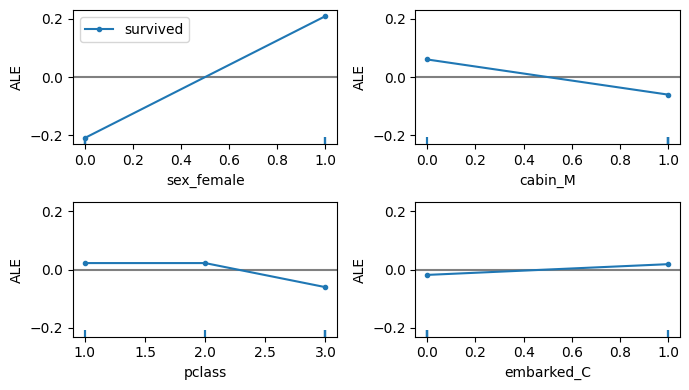

In [51]:
# After generating the ALE values we can plot them.
# in this example, we choose to plot the ALE only for the 4 important features (from XGBoost fi)

# get the important features
important_features = fi[fi > 0].index.tolist()

# plot for the important features ONLY, and also ONLY for the positive class "survived"
plot_ale(exp_xgbc, # explanation object 
         features=important_features, # if we do not specify a list of features here, the ALE will be plotted for all of the features provided in the X_test
         targets=target_names[1:], # if we do not specify target names, we will get ALE values for both classes: "did not survice" and "survived"; this parameter is a list so note the slicing
         n_cols=2, # specify how many columns in the plot we want
         fig_kw={'figwidth': 7, 'figheight': 4}); # specify figure size


 - The plot function created four graphs specifically for the four features that xgboost identified as important. 

 - On the X-axis, you'll find the different values of each feature, while the Y-axis shows ALE values in terms of probability. This is because we used the predict_proba function with the ALE explainer.

 - It's important to note that all the graphs are centered around 0, and the ALE values are in relative probability units with respect to the mean feature effect (mean ALE values for a feature).